Ce notebook a été entièrement réalisé par Mélnaie Gomis.

# ViT

In [1]:
# Installation de gdown si besoin
try:
    import gdown
except ImportError:
    %pip install -q gdown
    import gdown


In [4]:
import numpy as np
import glob
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import gdown
import matplotlib.pyplot as plt

# Chargement des données

In [3]:
"""
    os.chdir("../Données")
    fichiers_npz = glob.glob('*.npz')
    cosmos_files = [f for f in fichiers_npz if "COSMOS" in f]
"""

'\n    os.chdir("../Données")\n    fichiers_npz = glob.glob(\'*.npz\')\n    cosmos_files = [f for f in fichiers_npz if "COSMOS" in f]\n'

In [3]:
# On définit le nom du dossier
dossier_nom = "redshift"
url = "https://drive.google.com/drive/folders/1-tQH6rfB1XoF7ml98yqVn7Z2IQwGMUdK?usp=sharing"

# 2. LOGIQUE DE TÉLÉCHARGEMENT
if os.path.exists(dossier_nom):
    print(f"✅ Le dossier '{dossier_nom}' est déjà présent. Pas besoin de retélécharger !")
else:
    print(f"📥 Dossier introuvable. Téléchargement en cours...")
    gdown.download_folder(url, quiet=True, use_cookies=False)
    print("✅ Téléchargement terminé !")

# 3. CRÉATION DE LA LISTE DES FICHIERS (C'est ici que ça plantait avant)
# On scanne le dossier pour créer la liste 'dossier_local' quoi qu'il arrive
pattern = os.path.join(dossier_nom, "*") # ex: redshift/*
dossier_local = glob.glob(pattern)

# 4. AFFICHAGE JOLI
print(f"\nSuccès ! {len(dossier_local)} fichiers trouvés dans '{dossier_nom}'.")
print("Détail des fichiers :")

for chemin in dossier_local:
    # On extrait le nom du dossier et le nom du fichier
    dossier = os.path.dirname(chemin)   # ex: redshift
    fichier = os.path.basename(chemin)  # ex: COSMOS_...npz
    
    # Ton format demandé
    print(f"[{dossier}] :\t {fichier}")

✅ Le dossier 'redshift' est déjà présent. Pas besoin de retélécharger !

Succès ! 16 fichiers trouvés dans 'redshift'.
Détail des fichiers :
[redshift] :	 info4.csv
[redshift] :	 output_zphot_only.txt
[redshift] :	 info3.csv
[redshift] :	 COSMOS_v11_uijk_0020_spec_D.npz
[redshift] :	 cnn_architecture.png
[redshift] :	 info2.csv
[redshift] :	 COSMOS_v11_uijk_0001_photo_D.npz
[redshift] :	 COSMOS_v11_uijk_0073_spec_UD.npz
[redshift] :	 COSMOS_v11_uijk_0213_photo_UD.npz
[redshift] :	 XMM_LSS_v11_uijk_0006_spec_D.npz
[redshift] :	 best_photoz_model.pt
[redshift] :	 cnn_photoz_model.h5
[redshift] :	 XMM_LSS_v11_uijk_0162_phot_UD.npz
[redshift] :	 info.csv
[redshift] :	 XMM_LSS_v11_uijk_0162_phot_D.npz
[redshift] :	 tmp_csv


In [5]:
fichiers_npz = glob.glob('redshift/*.npz')
cosmos_files = [f for f in fichiers_npz if "COSMOS" in f]

# Listes séparées pour train et test
train_cubes_list = []
train_infos_list = []
train_flag_list = []

test_cubes_list = []
test_infos_list = []
test_flag_list = []

print(f"Chargement de {len(cosmos_files)} fichiers COSMOS.")

for fichier in cosmos_files:
    try:
        data = np.load(fichier, allow_pickle=True)
        
        # 'info' est un array structuré. 'dtype.names' donne les noms des colonnes.
        info_fields = data['info'].dtype.names
        
        # On vérifie si la *colonne* 'ZSPEC' existe dans ce fichier
        if 'ZSPEC' in info_fields:
            # Ce fichier contient des données de TEST (il a la colonne ZSPEC)
            test_cubes_list.append(data['cube'])
            test_infos_list.append(data['info'])
            test_flag_list.append(data['flag'])
        else:
            # Ce fichier contient des données de TRAIN (pas de colonne ZSPEC)
            train_cubes_list.append(data['cube'])
            train_infos_list.append(data['info'])
            train_flag_list.append(data['flag'])
            
            
    except Exception as e:
        print(f":x: Erreur en chargeant {fichier}: {e}")

print("Chargement terminé.")

Chargement de 4 fichiers COSMOS.
Chargement terminé.


In [6]:
# Création des jeux train/test

# Jeu d’entraînement (basé sur les fichiers SANS ZSPEC)
# On vérifie qu'on a bien trouvé des fichiers de train
if train_infos_list:
    X_train = np.concatenate(train_cubes_list, axis=0)
    infos_train = np.concatenate(train_infos_list, axis=0)
    flags_train = np.concatenate(train_flag_list, axis=0)
    y_train = infos_train['ZPHOT'] # Obtenir ZPHOT depuis les infos de train
    print(f"Objets d'entraînement (ZPHOT) : {len(y_train)}")
    print("X_train :", X_train.shape)
    print("y_train :", y_train.shape)
else:
    print("Aucun fichier d'entraînement (sans ZSPEC) trouvé.")

print("\n---\n")

# Jeu de test (basé sur les fichiers AVEC ZSPEC)
# On vérifie qu'on a bien trouvé des fichiers de test
if test_infos_list:
    X_test = np.concatenate(test_cubes_list, axis=0)
    infos_test = np.concatenate(test_infos_list, axis=0)
    flags_test = np.concatenate(test_flag_list, axis=0)
    y_test = infos_test['ZSPEC'] # Obtenir ZSPEC depuis les infos de test

    # Si on ne garde que les ZSPEC valides
    # mask_zspec_valid = ~np.isnan(y_test) ou ???
    # X_test = X_test[mask_zspec_valid]
    # y_test = y_test[mask_zspec_valid]

    print(f"Objets de test (ZSPEC) : {len(y_test)}")
    print("X_test  :", X_test.shape)
    print("y_test  :", y_test.shape)
else:
    print("Aucun fichier de test (avec ZSPEC) trouvé.")

Objets d'entraînement (ZPHOT) : 12497
X_train : (12497, 64, 64, 9)
y_train : (12497,)

---

Objets de test (ZSPEC) : 27
X_test  : (27, 64, 64, 9)
y_test  : (27,)


# Encodeur d’images (Image Encoder)

On veut des patchs précis mais pas trop lourd. 

- Patch embedding 
    - On utilisera des patchs de 16x16 feront l'affaire.
    - La projection se fera dans un embedding dimension de 512.
- Transformers 
    - On prendre 7 couches et 8 têtes (car 512 / 64 = 8).



In [7]:
X_train_tensor = torch.tensor(np.ascontiguousarray(X_train), dtype=torch.float32)
y_train_tensor = torch.tensor(np.ascontiguousarray(y_train), dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(np.ascontiguousarray(X_test), dtype=torch.float32)
y_test_tensor = torch.tensor(np.ascontiguousarray(y_test), dtype=torch.float32).unsqueeze(1)


In [8]:
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
# --- Patch Embedding ---
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=64, patch_size=16, in_channels=9, embed_dim=512):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.n_patches + 1, embed_dim))

    def forward(self, x):
        B, H, W, C = x.shape
        patches = x.unfold(1, self.patch_size, self.patch_size) \
                   .unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(B, -1, self.patch_size * self.patch_size*C)
        patches = self.proj(patches)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, patches), dim=1)
        x = x + self.pos_embed
        return x

# --- Transformer Block ---
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, mlp_dim=2048, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )

    def forward(self, x):
        x_ = self.ln1(x)
        x_attn, _ = self.attn(x_, x_, x_)
        x = x + x_attn
        x = x + self.mlp(self.ln2(x))
        return x

# --- ViT Image Encoder ---
class ViTImageEncoder(nn.Module):
    def __init__(self, img_size=64, patch_size=16, in_channels=9, embed_dim=512,
                 depth=7, num_heads=8, mlp_dim=2048):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_dim) for _ in range(depth)
        ])
        self.ln = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.permute(1, 0, 2)  # seq_len, batch, embed_dim
        for blk in self.transformer_blocks:
            x = blk(x)
        x = x.permute(1, 0, 2)  # batch, seq_len, embed_dim
        x = self.ln(x)
        cls_embedding = x[:, 0, :]
        return cls_embedding


In [ ]:
""" class ParamMLP(nn.Module): 
    def __init__(self, input_dim=1, embed_dim=512):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
    def forward(self, x):
        return self.fc(x)
 """

In [10]:
class ViTRegressor(nn.Module):
    def __init__(self, img_size=64, patch_size=16, in_channels=9,
                 embed_dim=512, depth=7, num_heads=8, mlp_dim=2048):
        super().__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer

        # ViT encodeur
        self.vit = ViTImageEncoder(img_size, patch_size, in_channels,
                                   embed_dim, depth, num_heads, mlp_dim)
        
        # couche finale pour prédire ZPHOT
        self.regressor = nn.Linear(embed_dim, 1)
        
    def forward(self, x):
        embedding = self.vit(x)  # B, 512
        zphot_pred = self.regressor(embedding)  # B,1
        return zphot_pred


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ViTRegressor().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Une époque prends environs 13.25 secondes avec les GPU T4 de Google Colab.

In [18]:
num_epochs = 200 # augmenter si nécessaire
tps = 13.25
tps_approx = tps * num_epochs


# Conversion des secondes en jours, heures et minutes
jours = tps_approx // (24 * 3600)
tps_approx %= (24 * 3600)
heures = tps_approx // 3600
tps_approx %= 3600
minutes = tps_approx // 60
secondes = tps_approx % 60


# Affichage
print(f"Temps approximatif : {int(jours)} J {int(heures)} h {int(minutes)} min")

Temps approximatif : 0 J 0 h 44 min


In [ ]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")
    
    # évaluation rapide sur test
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            test_loss += criterion(pred, yb).item() * xb.size(0)
        test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f"Test Loss: {test_loss:.4f}\n")


Epoch 1/200, Train Loss: 0.7735
Test Loss: 2.5668

Epoch 2/200, Train Loss: 0.6154
Test Loss: 2.2312

Epoch 3/200, Train Loss: 0.5631
Test Loss: 2.1352

Epoch 4/200, Train Loss: 0.5409
Test Loss: 2.3510

Epoch 5/200, Train Loss: 0.5084
Test Loss: 2.5589

Epoch 6/200, Train Loss: 0.4768
Test Loss: 2.0330

Epoch 7/200, Train Loss: 0.4410
Test Loss: 2.9845

Epoch 8/200, Train Loss: 0.4178
Test Loss: 2.6630

Epoch 9/200, Train Loss: 0.3986
Test Loss: 3.2617

Epoch 10/200, Train Loss: 0.3700
Test Loss: 3.4567

Epoch 11/200, Train Loss: 0.3507
Test Loss: 3.2278

Epoch 12/200, Train Loss: 0.3314
Test Loss: 3.2269

Epoch 13/200, Train Loss: 0.3151
Test Loss: 3.7711

Epoch 14/200, Train Loss: 0.3078
Test Loss: 3.2849

Epoch 15/200, Train Loss: 0.2931
Test Loss: 3.1386

Epoch 16/200, Train Loss: 0.2667
Test Loss: 3.5274

Epoch 17/200, Train Loss: 0.2625
Test Loss: 3.0844

Epoch 18/200, Train Loss: 0.2455
Test Loss: 3.7791

Epoch 19/200, Train Loss: 0.2269
Test Loss: 4.4711

Epoch 20/200, Train L

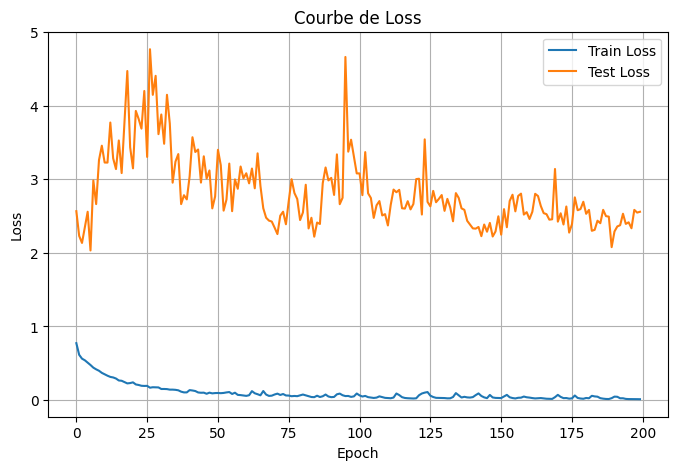

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de Loss")
plt.legend()
plt.grid(True)
plt.show()


# Classification

Au lieu de faire une régression, on va faire une classification.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [13]:
# Classe pour le modèle ViT
class ViTModel(nn.Module):
    def __init__(self, num_classes=200):  # Paramètre pour spécifier le nombre de classes
        super(ViTModel, self).__init__()
        # Exemple d'utilisation d'un modèle ViT pré-entrainé (par ex., de Hugging Face ou PyTorch)
        # Ici, on suppose l'utilisation d'un modèle préexistant, comme ViT-B/16 de Hugging Face
        self.vit = models.vit_b_16(pretrained=True)  # Charger le modèle ViT pré-entrainé
        
        # Remplacer la couche de classification pour correspondre au nombre de classes
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

# Classe pour entraîner et gérer le modèle
class ViTTrainer:
    def __init__(self, num_classes=200, lr=1e-4):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = ViTModel(num_classes=num_classes).to(self.device)
        
        # Définir le critère de perte et l'optimiseur
        self.criterion = nn.CrossEntropyLoss()  # Utilisation de la CrossEntropyLoss pour la classification
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
    def train(self, train_loader, num_epochs=10):
        self.model.train()  # Mettre le modèle en mode entraînement
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                self.optimizer.zero_grad()  # Zéroiser les gradients
                
                outputs = self.model(inputs)  # Passer les entrées dans le modèle
                loss = self.criterion(outputs, labels)  # Calculer la perte
                
                loss.backward()  # Calculer les gradients
                self.optimizer.step()  # Mettre à jour les poids
                
                running_loss += loss.item()
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")
    
    def evaluate(self, val_loader):
        self.model.eval()  # Mettre le modèle en mode évaluation
        correct = 0
        total = 0
        with torch.no_grad():  # Ne pas calculer les gradients pour l'évaluation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)  # Obtenir la classe avec la probabilité la plus élevée
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = correct / total * 100
        print(f"Accuracy: {accuracy:.2f}%")

In [19]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")
    
    # évaluation rapide sur test
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            test_loss += criterion(pred, yb).item() * xb.size(0)
        test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f"Test Loss: {test_loss:.4f}\n")


Epoch 1/200, Train Loss: 0.0132
Test Loss: 2.5141

Epoch 2/200, Train Loss: 0.0119
Test Loss: 2.4965

Epoch 3/200, Train Loss: 0.0149
Test Loss: 2.5709

Epoch 4/200, Train Loss: 0.0165
Test Loss: 2.3945

Epoch 5/200, Train Loss: 0.0426
Test Loss: 2.7406

Epoch 6/200, Train Loss: 0.0309
Test Loss: 2.4697

Epoch 7/200, Train Loss: 0.0188
Test Loss: 2.4739

Epoch 8/200, Train Loss: 0.0138
Test Loss: 2.4548

Epoch 9/200, Train Loss: 0.0111
Test Loss: 2.4102

Epoch 10/200, Train Loss: 0.0103
Test Loss: 2.4567

Epoch 11/200, Train Loss: 0.0487
Test Loss: 2.2159

Epoch 12/200, Train Loss: 0.0402
Test Loss: 2.7992

Epoch 13/200, Train Loss: 0.0236
Test Loss: 2.5268

Epoch 14/200, Train Loss: 0.0166
Test Loss: 2.5181

Epoch 15/200, Train Loss: 0.0124
Test Loss: 2.5226

Epoch 16/200, Train Loss: 0.0706
Test Loss: 2.3652

Epoch 17/200, Train Loss: 0.0404
Test Loss: 2.5763

Epoch 18/200, Train Loss: 0.0366
Test Loss: 2.4411

Epoch 19/200, Train Loss: 0.0209
Test Loss: 2.2994

Epoch 20/200, Train L

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de Loss")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'train_losses' is not defined

<Figure size 800x500 with 0 Axes>

## +++

In [15]:
# --- Nettoyage des sentinelles dans les images ---
sentinel_threshold = -99

X_train[X_train < sentinel_threshold] = np.nan
X_test[X_test < sentinel_threshold] = np.nan

In [16]:
y_train = infos_train['ZPHOT']
y_test = infos_test['ZSPEC']

In [19]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")
    
    # évaluation rapide sur test
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            test_loss += criterion(pred, yb).item() * xb.size(0)
        test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f"Test Loss: {test_loss:.4f}\n")


Epoch 1/200, Train Loss: 0.7653
Test Loss: 2.3055

Epoch 2/200, Train Loss: 0.5992
Test Loss: 2.5503

Epoch 3/200, Train Loss: 0.5615
Test Loss: 2.2563

Epoch 4/200, Train Loss: 0.5255
Test Loss: 2.3592

Epoch 5/200, Train Loss: 0.4944
Test Loss: 2.1725

Epoch 6/200, Train Loss: 0.4659
Test Loss: 2.2048

Epoch 7/200, Train Loss: 0.4529
Test Loss: 2.1188

Epoch 8/200, Train Loss: 0.4282
Test Loss: 2.2796

Epoch 9/200, Train Loss: 0.3992
Test Loss: 2.1141

Epoch 10/200, Train Loss: 0.3851
Test Loss: 2.3707

Epoch 11/200, Train Loss: 0.3695
Test Loss: 2.5828

Epoch 12/200, Train Loss: 0.3574
Test Loss: 2.5462

Epoch 13/200, Train Loss: 0.3389
Test Loss: 2.8784

Epoch 14/200, Train Loss: 0.3257
Test Loss: 2.8081

Epoch 15/200, Train Loss: 0.3062
Test Loss: 3.0058

Epoch 16/200, Train Loss: 0.2940
Test Loss: 2.7186

Epoch 17/200, Train Loss: 0.2834
Test Loss: 2.6197

Epoch 18/200, Train Loss: 0.2667
Test Loss: 2.9420

Epoch 19/200, Train Loss: 0.2589
Test Loss: 2.9284

Epoch 20/200, Train L

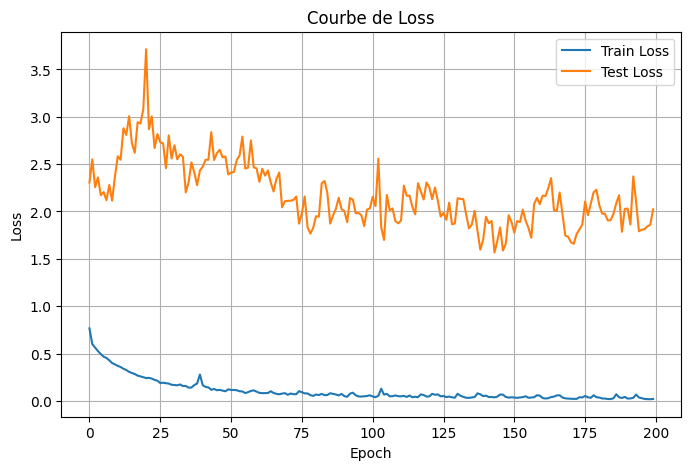

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de Loss")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
model.eval()
mae_total = 0.0

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        mae_total += torch.abs(pred - yb).sum().item()

mae_final = mae_total / len(test_loader.dataset)

print(f"\nMAE finale sur le test set : {mae_final:.5f}")



MAE finale sur le test set : 0.83350


In [ ]:
model.eval()

z_pred_list = []
z_true_list = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb)

        z_pred_list.append(pred.cpu().numpy())
        z_true_list.append(yb.numpy())

# Concaténer tout
z_pred = np.concatenate(z_pred_list).flatten()
z_true = np.concatenate(z_true_list).flatten()

# --- Calcul des métriques photo-z ---

delta_z = z_pred - z_true
delta_z_norm = delta_z / (1 + z_true)

# Sigma NMAD
sigma_nmad = 1.48 * np.median(
    np.abs(delta_z_norm - np.median(delta_z_norm))
)

# Biais
bias = np.mean(delta_z_norm)

# Taux d'outliers (|Δz_norm| > 0.15)
outlier_mask = np.abs(delta_z_norm) > 0.15
tau = np.sum(outlier_mask) / len(delta_z_norm)

print("\n===== MÉTRIQUES PHOTO-Z =====")
print(f"Sigma_NMAD : {sigma_nmad:.5f}")
print(f"Biais      : {bias:.5f}")
print(f"(outliers >0.15) : {tau:.5f}")


===== MÉTRIQUES PHOTO-Z =====
Sigma_NMAD : 0.27739
Biais      : 0.20737
Tau (outliers >0.15) : 0.59259
